# PROJECT 4: Bird Classification

Team 3:
- Diego Abel Cuevas Gonzalez
- Amine Hamane
- Katherine Gonzalez

In [1]:
import pandas as pd

#Use csv file to check the 15 birds with the most training pictures to only load those onto drive
birds_df = pd.read_csv("birds.csv")
birds_train = birds_df[birds_df['data set'] == 'train']
most_data = sorted(birds_train['labels'].value_counts().nlargest(15).index.tolist()) #in alphabetical order to make them easier to look up
most_data

['ASIAN GREEN BEE EATER',
 'CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'FRILL BACK PIGEON',
 'HOUSE FINCH',
 'MERLIN',
 'MILITARY MACAW',
 'ORNATE HAWK EAGLE',
 'OVENBIRD',
 'PYRRHULOXIA',
 'RED BILLED TROPICBIRD',
 'RUFOUS TREPE',
 'SWINHOES PHEASANT',
 'WOOD DUCK',
 'WOOD THRUSH']

**Defining directories and checking that train, test and valid contain only the chosen birds**

In [7]:
import os

class PATH:
        TRAIN = '../Bird_classification_model/data/train'
        VALID = '../Bird_classification_model/data/valid'
        TEST = '../Bird_classification_model/data/test'

train_files = os.listdir(PATH.TRAIN)
valid_files = os.listdir(PATH.VALID)
test_files = os.listdir(PATH.TEST)


# Check if the filenames are the same
if sorted(train_files) != most_data :
    print("Train_files is incorrect")

if sorted(test_files) != most_data :
    print("Test_files is incorrect")

if sorted(valid_files) != most_data :
    print("Valid_files is incorrect")

#if nothing is printed, train, test and validation include the 15 desired birds

**Building a dataframe that includes the image path and the y_label**

In [9]:

def create_dataset(path, birds):
    data = {"imgpaths": [], "labels": []}
    paths = os.listdir(path)

    for bird in birds:
        if bird in paths:
            bird_path = os.path.join(path, bird)
            filelist = os.listdir(bird_path)
            for file in filelist:
                file_path = os.path.join(bird_path, file)
                data["imgpaths"].append(file_path)
                data["labels"].append(bird)

    return pd.DataFrame(data)

train_df = create_dataset(PATH.TRAIN, most_data)
valid_df = create_dataset(PATH.VALID, most_data)
test_df = create_dataset(PATH.TEST, most_data)

#randomise rows so that not all instances of the same bird follow each other
SEED = 53

train_df = train_df.sample(frac=1, random_state = SEED).reset_index(drop=True)
valid_df = valid_df.sample(frac=1, random_state = SEED).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state = SEED).reset_index(drop=True)


**We then encoded the labels to assign each bird a number from 0 to 14.**

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_df['encoded_labels'] = encoder.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = encoder.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = encoder.fit_transform(test_df['labels'])
train_df

,imgpaths,labels,encoded_labels
0,../Bird_classification_model/data/train\OVENBI...,OVENBIRD,8
1,../Bird_classification_model/data/train\MERLIN...,MERLIN,5
2,../Bird_classification_model/data/train\MERLIN...,MERLIN,5
3,../Bird_classification_model/data/train\HOUSE ...,HOUSE FINCH,4
4,../Bird_classification_model/data/train\MILITA...,MILITARY MACAW,6
...,...,...,...
3301,../Bird_classification_model/data/train\WOOD T...,WOOD THRUSH,14
3302,../Bird_classification_model/data/train\OVENBI...,OVENBIRD,8
3303,../Bird_classification_model/data/train\RUFOUS...,RUFOUS TREPE,11
3304,../Bird_classification_model/data/train\WOOD D...,WOOD DUCK,13


**Here is a sample image of each bird.**

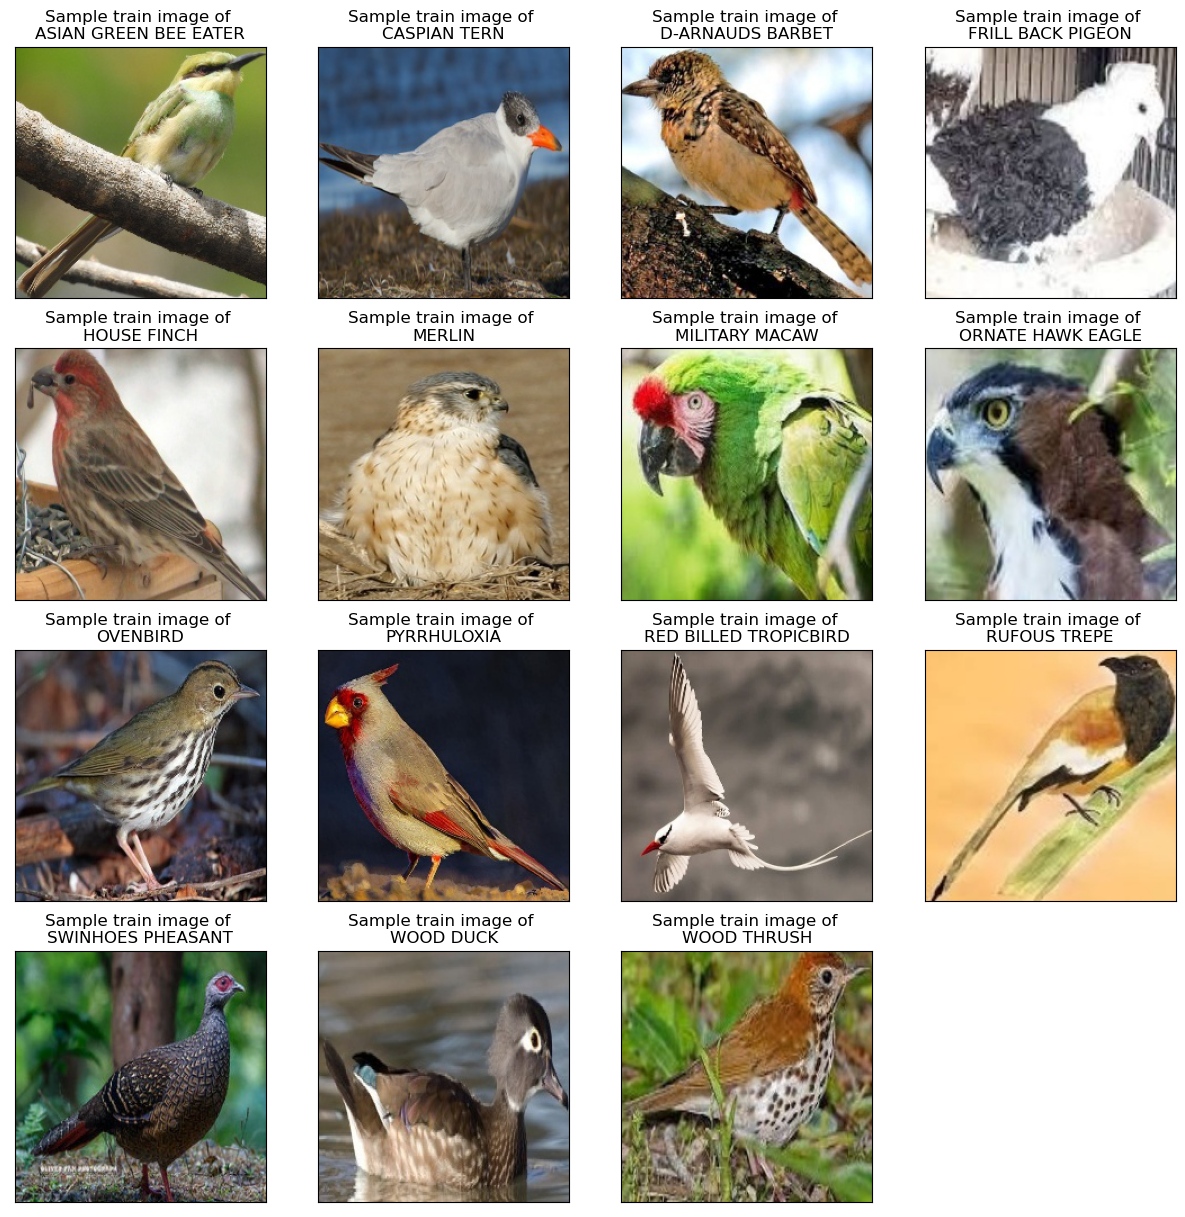

In [11]:
# Visualize the distribution of the train data
import matplotlib.pyplot as plt
from PIL import Image

sample_df = train_df.groupby('encoded_labels').agg('first')

plt.figure(figsize=(15,15))
for i in sample_df.index.tolist():
    img = Image.open(sample_df.loc[i, 'imgpaths'])
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.title(f'Sample train image of \n{sample_df.loc[i, "labels"]}')
plt.show()

**Here we are preparing a dataset that pairs preprocessed images with the respective one-hot encoded labels we did in previous cells**

**We then apply data augmentation to increase and transform the dataset to make it more diverse. this will help introduce slighty different examples from the data that has already been provided and this will help the model's performance when we introduce new data.**

**Lastly we organize the data in a proper format for training using TensorFlow modelling, which includes a horizontal/vertical flip, rotation and zoom.**

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Randomly flip an image horizontally (left to right).
    image = tf.image.random_flip_up_down(image)    # Randomly flip an image vertically (upside down).
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change brightness.
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)  # Randomly change contrast.
    # Additional augmentation operations...
    image = tf.image.random_rotation(image, 0.2) # Random rotation
    image = tf.image.random_zoom(image, 0.2)     # Random zoom
    return image


def load_and_preprocess_image(path):

    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image


def create_images_dataset(df):
    paths = df['imgpaths'].values
    image_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = image_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return image_ds

def create_labels_dataset(df, num_classes):
    labels = df['encoded_labels'].values
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    labels_ds = labels_ds.map(lambda x: tf.one_hot(x, num_classes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return labels_ds

def create_combined_dataset(images_ds, labels_ds):
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    return ds

**We then created an X and y variable from the dataframes. X is the images transformed to arrays and y is a list of the corresponding encoded labels.**

In [13]:
num_classes = len(encoder.classes_)

X_train = create_images_dataset(train_df)
y_train = create_labels_dataset(train_df, num_classes)
train_dataset = create_combined_dataset(X_train, y_train)

X_valid = create_images_dataset(valid_df)
y_valid = create_labels_dataset(valid_df, num_classes)
valid_dataset = create_combined_dataset(X_valid, y_valid)

X_test = create_images_dataset(test_df)
y_test = create_labels_dataset(test_df, num_classes)
test_dataset = create_combined_dataset(X_test, y_test)

In [14]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_valid))
print(len(y_valid))
#the lengths correspond

3306
3306
75
75
75
75


**We then built the model using Keras, starting with the inputs, followed by a series of convolutional layers (4), max-pooling layers (4), and additional dropout for regularization, culminating in the output layer with softmax activation.**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

input_shape = (224, 224, 3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),  # Additional Conv2D layer
        layers.MaxPooling2D(pool_size=(2, 2)),  # Additional MaxPooling2D layer
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

**We compiled the model using Adam optimizer, categorical crossentropy loss and an accuracy metric and trained it with batches of 90 instances and 17 epochs.**

In [16]:
# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Batch and zip the datasets
batch_size = 90
epochs = 17

# Batch and zip the datasets
train_dataset = tf.data.Dataset.zip((X_train, y_train)).batch(batch_size)
valid_dataset = tf.data.Dataset.zip((X_valid, y_valid)).batch(batch_size)
test_dataset = tf.data.Dataset.zip((X_test, y_test)).batch(batch_size)

# Fit the model
#model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)
history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)

# Evaluate the model
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

KeyboardInterrupt: 

**For Loss Curves we see both training and validation loss gradually decrease over the epochs, which is good and means that the model is learning and improving its performance on both the training and validation data.**

**For Accuracy Curves both training and validation accuracy increase over the epochs. The model become more accurate in predicting the correct labels for the data. The validation accuracy slightly lower than the training accuracy**

**Overall the model shows to be learning well and is generalizing to unseen data, as evidenced in the plots: loss decreases while accurazy increases for both training and validation datasets.**

In [ ]:
import matplotlib.pyplot as plt

# Assuming that you have history object from your model fit

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Plotting a confussion matrix using heatmap, we see the majority of predictions are correct while very few misclassifications are represented. Overall very good acurate predictions across our different classes in the model**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get model's predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert one-hot encoded predictions to class indices

# Extract actual labels from y_test
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1) # Convert one-hot encoded labels to class indices

# Create confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


**Function to determine which parts of the image contributed more to the clasificastion decision made by our CNN Model.**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    return cam_path

In [ ]:
# Get predictions on the test set
predictions = model.predict(valid_dataset)

# Convert predictions classes to one hot vectors
predictions_classes = np.argmax(predictions, axis = 1)

img_size = (224, 224)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

# Getting some random images for display
random_indices = np.random.randint(0, len(valid_df), size=10)

for i, ax in enumerate(axes.flat):
    index = random_indices[i]
    img_path = valid_df.imgpaths.iloc[index]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_3')
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {encoder.classes_[valid_df.encoded_labels.iloc[index]]}\nPredicted: {encoder.classes_[predictions_classes[index]]}")
plt.tight_layout()
plt.show()